![clothing_classification](clothing_classification.png)


Fashion Forward is a new AI-based e-commerce clothing retailer.
They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.

In [1]:
# Run the cells below first

In [2]:
# !pip install torchmetrics
# !pip install torchvision

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


C:\Users\Alienware\miniconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load datasets
# The FashionMNIST dataset is a collection of grayscale images of clothing items
# The images are transformed into PyTorch tensors using transforms.ToTensor()

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
image, label = train_data[0] # Access the first element in the dataset
image.shape, label

# Image: Each image is a tensor of shape [1, 28, 28], representing 1 channel (grayscale) and 28x28 pixels.
# Label: Each label is an integer representing the class of the clothing item (0 to 9).

(torch.Size([1, 28, 28]), 9)

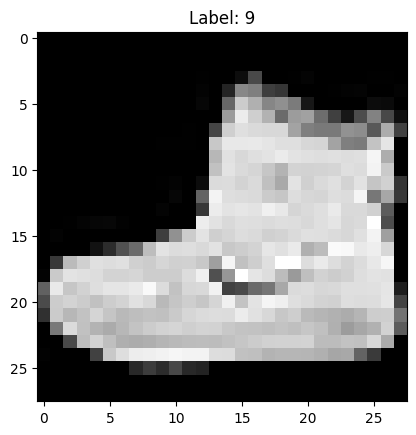

In [7]:
# visualize Example image and label

# Convert the tensor to a NumPy array and plot it
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.show()


The labels correspond to the following classes:

0 T-shirt/top

1 Trouser

2 Pullover

3 Dress

4 Coat

5 Sandal

6 Shirt

7 Sneaker

8 Bag

9 Ankle boot

Automate product tagging for the e-commerce store using CNNs.

Once trained (keeping the epochs to 1 or 2 to keep the run time down), store your predictions on the test set in a list named predictions.

Calculate the accuracy, and per-class precision and recall for your classifier based on the predictions obtained. Store your metrics in variables named accuracy, precision, and recall. Use lists of the appropriate length for the precision and recall.

In [8]:
# Get the number of classes
classes = train_data.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [9]:
num_classes = len(classes)
num_classes

10

In [10]:
print(train_data[0][0].shape)
train_data[0][1]

torch.Size([1, 28, 28])


9

In [11]:
image_size = train_data[0][0].shape[1]
image_size

28

In [12]:
# Define some relevant variables
num_input_channels = 1 # 1 channel for grayscale, 3 for RGB
num_output_channels = 16 # number of filters or kernels to use

In [13]:
# Define CNN
class MultiClassImageClassifier(nn.Module):
  
    # Define the init method
    def __init__(self, num_classes):
        super(MultiClassImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(num_input_channels, num_output_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        # Create a fully connected layer
        self.fc = nn.Linear(num_output_channels * (image_size//2)**2, num_classes) 
        # //2 because, when using a stride of 2, each pooling operation reduces the dimensions of the feature map by a factor of 2 (then we square to get all values)
        # We multiply by num_output_channels to account for all the feature maps produced by the convolutional layer (each filter (or kernel) applied to the input produces one feature map)
        
    def forward(self, x):
        # Pass inputs through each layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [14]:
for features, labels in train_data:
    print(features.shape)
    print(labels)
    break

torch.Size([1, 28, 28])
9


In [15]:
batch_size = 10

# Define the training set DataLoader
dataloader_train = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)

In [16]:
for features, labels in dataloader_train:
    print(features.shape)
    print(labels)
    break

torch.Size([10, 1, 28, 28])
tensor([4, 2, 0, 3, 4, 0, 8, 6, 4, 4])


In [17]:
# Define training function
def train_model(optimizer, net, num_epochs):
    num_processed = 0
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        running_loss = 0
        num_processed = 0
        
        for features, labels in dataloader_train:
            optimizer.zero_grad() # Resets the gradients of all the model parameters to zero. This prevents gradients from accumulating, ensuring that each optimization step uses fresh gradients.
            outputs = net(features)
            loss = criterion(outputs, labels)
            loss.backward() # computes the gradient of the loss with respect to each parameter (weight) in the model.
            optimizer.step() # updates the parameters of the model based on the computed gradients.
            running_loss += loss.item()
            num_processed += len(labels)
            print('epoch:', epoch+1, 
                  'batch_size:',batch_size,
                  'len_dataloader_train:', len(dataloader_train), 
                  'num_processed:', num_processed,
                  'running_loss:', running_loss / num_processed,
                  end='\r')
            
    train_loss = running_loss / len(dataloader_train)
    print('epoch:', epoch+1, 
          'batch_size:', batch_size,
          'len_dataloader_train:', len(dataloader_train), 
          'num_processed:', num_processed,
          'train_loss:', train_loss)

In [18]:
# Train for 1 epoch
net = MultiClassImageClassifier(num_classes)
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_model(
    optimizer=optimizer,
    net=net,
    num_epochs=1,
)

epoch: 1 batch_size: 10 len_dataloader_train: 6000 num_processed: 60000 train_loss: 0.39553910159443817826 batch_size: 10 len_dataloader_train: 6000 num_processed: 1310 running_loss: 0.11438860176628783 1 batch_size: 10 len_dataloader_train: 6000 num_processed: 38350 running_loss: 0.043292765229857845


In [19]:
# Test the model on the test set
              
# Define the test set DataLoader
dataloader_test = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
)

In [20]:
for features, labels in dataloader_test:
    print(features.shape)
    print(labels)
    break

torch.Size([10, 1, 28, 28])
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])


In [21]:
# Define the metrics (average=None computes metrics globally by counting the total true positives, false negatives, and false positives)
accuracy_metric = Accuracy(task='multiclass', num_classes=num_classes)
precision_metric = Precision(task='multiclass', num_classes=num_classes, average=None)
recall_metric = Recall(task='multiclass', num_classes=num_classes, average=None)

In [22]:
# Run model on test set
net.eval()
predictions = []
for i, (features, labels) in enumerate(dataloader_test):

    # output = net.forward(features.reshape(-1, 1, image_size, image_size))
    output = net.forward(features)
    cat = torch.argmax(output, dim=-1)
    predictions.extend(cat.tolist())
    # below we calculate the scoring metrics at each iteration, and then we use the method compute() afterwards to calculate their total value
    # this way we don't need to create specific lists to store all predictions and labels at each iteration
    accuracy_metric(cat, labels)
    precision_metric(cat, labels)
    recall_metric(cat, labels)
    print('iter:', i, end='\r')

# just printing the shapes of the last iteration
print(features.shape)
print(features.reshape(-1, 1, image_size, image_size).shape)
print(output.shape) # 10 predictions * 10 batches
print(cat)

torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 28, 28])
torch.Size([10, 10])
tensor([5, 6, 8, 9, 1, 9, 1, 8, 1, 5])


In [23]:
accuracy_metric.compute()

tensor(0.8790)

In [24]:
precision_metric.compute()

tensor([0.8984, 0.9740, 0.8951, 0.8770, 0.7888, 0.9818, 0.6177, 0.9486, 0.9343,
        0.9424])

In [25]:
recall_metric.compute()

tensor([0.7340, 0.9750, 0.7250, 0.8980, 0.8480, 0.9690, 0.7530, 0.9420, 0.9810,
        0.9650])

In [26]:
# Compute the metrics
accuracy = accuracy_metric.compute().item()
precision = precision_metric.compute().tolist()
recall = recall_metric.compute().tolist()
print('Accuracy:', accuracy)
print('Precision (per class):', precision)
print('Recall (per class):', recall)

Accuracy: 0.8790000081062317
Precision (per class): [0.898408830165863, 0.9740259647369385, 0.895061731338501, 0.876953125, 0.788837194442749, 0.9817629456520081, 0.6177194714546204, 0.9486404657363892, 0.9342857003211975, 0.9423828125]
Recall (per class): [0.734000027179718, 0.9750000238418579, 0.7250000238418579, 0.8980000019073486, 0.8479999899864197, 0.968999981880188, 0.753000020980835, 0.9419999718666077, 0.9810000061988831, 0.9649999737739563]
